# RBF Regression on Boston hosting Dataset
### Charis Filis
### Academic-id : 9449 

Add needed dependencies

In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [2]:
import tensorflow as tf
# Import  tensorflow.keras basic NNet modules for the RBF output layer
from tensorflow.keras import layers,models
from tensorflow.keras import initializers
# Import tensorflow.keras backend for any tensor operations
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import boston_housing
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import addons for RSqure metric
import tensorflow_addons as tfa
from tensorflow.keras.metrics import RootMeanSquaredError
# Import pairwise metric 
from sklearn.metrics import pairwise
# Import KMeans algorithm in case the custom one does not work properly
from sklearn.cluster import KMeans
# Import numpy for array and numeric operations
import numpy as np

In [3]:
(x_train, y_train),(x_test, y_test) = boston_housing.load_data(test_split=0.25)


#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)
# get per-feature statistics (mean,standard deviation ) from the training set in order to make normalization
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train,axis=0)
x_train = (x_train-train_mean)/train_std
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print("Training data shape:",x_train.shape)
print("Training y train shape", y_train.shape)
print("Testing data shape:",x_test.shape)


Number of original training examples: 379
Number of original test examples: 127
Training data shape: (379, 13)
Training y train shape (379,)
Testing data shape: (127, 13)


R squared metric custom made 

In [4]:
def R2(test_val, pred_val):
    SS_res = K.sum(K.square(test_val-pred_val))
    SS_tot = K.sum(K.square(test_val-K.mean(test_val)))
    return (1 - SS_res/(SS_tot+K.epsilon()))

Model 1 compute centers and sigma and Number of Kernels = 0.1 Ntrain

In [5]:
from scipy.spatial.distance import pdist
# Variance of each kernel
from cmath import sqrt
# num of kernels in hidden layer = number of inputs = number of nodes of  RBF layer
n_centers = int(0.1*x_train.shape[0])
print(n_centers)
def computeSigma(n_centers):
        km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
        centers = km.cluster_centers_
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
        return sigma
   
sigma = computeSigma(n_centers)
print(sigma)

37
tf.Tensor(1.2130247, shape=(), dtype=float32)


In [6]:
from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_
        

Create RBF layer or RBF kernel would be described

In [7]:
from tensorflow.keras.layers import Layer
from keras import backend as K
from keras.initializers import RandomNormal, Initializer, Constant
import numpy as np

class RBFLayer(Layer):
    """
        RBF Layer applying Gaussian Kernel
        # Arguments
        units := number of neurons
        initializer := weight or centroid initializer for each neuron Kmean is used
        b := thresholds of output layer
    """
    def __init__(self,units,sigmaInit,initializer=None,b=1.0,**kwargs):
        self.init_betas = b
        self.units = units
        self.sigmaInit = sigmaInit
        if not initializer:
            self.initializer = RandomNormal(mean = 0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # I initialize the weights of rbf layer with kmeans 
        self.W = self.add_weight(name='W',
                                 shape=(self.units,input_shape[1]),
                                 initializer=self.initializer,
                                 trainable=True)
        self.b  = self.add_weight(shape=(self.units,),
                            initializer=Constant(value=self.init_betas),
                            trainable=True)

        super(RBFLayer,self).build(input_shape)
    
    # radial basis function
    def call(self, inputs):
        diff = K.expand_dims(self.W) 
        H = K.transpose(diff - K.transpose(inputs)) 
        # take L2 norm for the exponent of the radial basis function
        l2 = K.sum(K.pow(H,2), axis=1)
        res = K.exp((-self.b * l2)/(2*(self.sigmaInit**2)))     
        return res

    def compute_output_shape(self, input_shape):
        return ( self.units,input_shape[0])
    
    # define get_config function to use model_from_jason
    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'units': self.units
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
                                 
        
    
    

In [8]:
# RBF layer optimiztion run afterwards
def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))
def run_optimization(rbf_layer):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        loss = mean_square(model_out.predict(x_train), y_train)
        # Compute gradients.
        gradients = g.gradient(loss, [rbf_layer.W, rbf_layer.b])
        # Update W and b following gradients.
        optimizer.apply_gradients(zip(gradients, [rbf_layer.W, rbf_layer.b]))
def RMSE(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

### Create 1st model builder function

Train output layer

In [17]:
model_out = models.Sequential()
rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
model_out.add(rbf_layer)

# Output Layer
model_out.add(layers.Dense(128,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))

# Make the linear tranformation layer on the output layer
model_out.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
model_out.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss=RMSE,
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
model_out.summary()
history_1 = model_out.fit(x_train,y_train,epochs=1000,batch_size=32,validation_split=0.2,verbose=1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_4 (RBFLayer)      (None, 37)                518       
                                                                 
 dense_8 (Dense)             (None, 128)               4864      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 1s 23ms/step - loss: 23.0184 - root_mean_squared_error: 23.0725 - R2: -6.4640 - val_loss: 27.2501 - val_root_mean_squared_error: 27.3373 - val_R2: -7.8501
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 22.9475 - root_mean_squared_error

Model 1


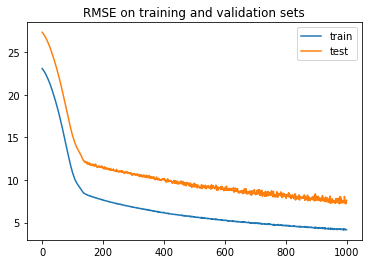

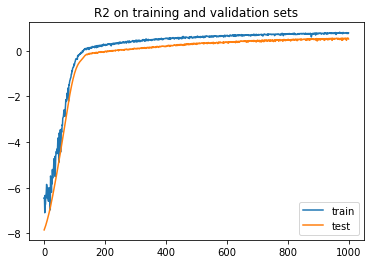

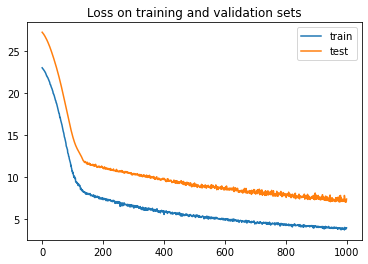

In [25]:

print("Model 1")
# Plot RMSE
plt.figure(1)
plt.plot(history_1.history['root_mean_squared_error'],label='train')
plt.plot(history_1.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
plt.figure()
plt.plot(history_1.history['R2'],label='train')
plt.plot(history_1.history['val_R2'],label='test')
plt.legend()
plt.title('R2 on training and validation sets')
plt.show()
# Plot loss
plt.figure(2)
plt.plot(history_1.history['loss'],label='train')
plt.plot(history_1.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

### Case 2  Model 2 compute centers and sigma and Number of Kernels = 0.5 Ntrain

In [11]:
from scipy.spatial.distance import pdist
# Variance of each kernel
from cmath import sqrt
# num of kernels in hidden layer = number of inputs = number of nodes of  RBF layer
n_centers = int(0.5*x_train.shape[0])
print(n_centers)
def computeSigma(n_centers):
        km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
        centers = km.cluster_centers_
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
        return sigma
   
sigma = computeSigma(n_centers)
print(sigma)

189
tf.Tensor(0.67237216, shape=(), dtype=float32)


### Create Model 2 and train it 

In [20]:
model_2 = models.Sequential()
rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
model_2.add(rbf_layer)

# Output Layer
model_2.add(layers.Dense(128,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))

# Make the linear tranformation layer on the output layer
model_2.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
model_2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
model_2.summary()
history_2 = model_out.fit(x_train,y_train,epochs=1000,batch_size=32,validation_split=0.2,verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_5 (RBFLayer)      (None, 37)                518       
                                                                 
 dense_10 (Dense)            (None, 128)               4864      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 0s 9ms/step - loss: 3.8013 - root_mean_squared_error: 4.1609 - R2: 0.7989 - val_loss: 7.2695 - val_root_mean_squared_error: 7.4816 - val_R2: 0.5283
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 3.9474 - root_mean_squared_error: 4.1718

### Print Results

Model 2


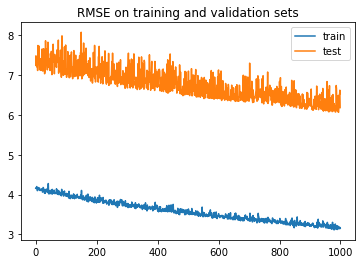

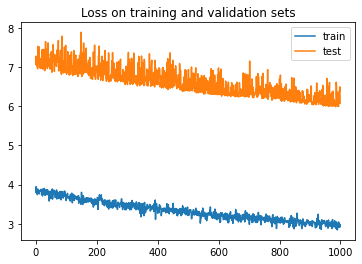

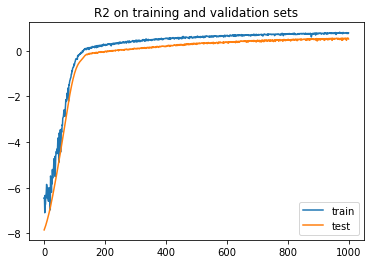

In [26]:
print("Model 2")
# Plot RMSE
plt.figure(3)
plt.plot(history_2.history['root_mean_squared_error'],label='train')
plt.plot(history_2.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
# Plot loss
plt.figure(4)
plt.plot(history_2.history['loss'],label='train')
plt.plot(history_2.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()
plt.figure()
plt.plot(history_1.history['R2'],label='train')
plt.plot(history_1.history['val_R2'],label='test')
plt.legend()
plt.title('R2 on training and validation sets')
plt.show()

### Case 3 - Model 3 with clusters = 90% training set  = RBF neurons

In [14]:
from scipy.spatial.distance import pdist
# Variance of each kernel
from cmath import sqrt
# num of kernels in hidden layer = number of inputs = number of nodes of  RBF layer
n_centers = int(0.9*x_train.shape[0])
print(n_centers)
def computeSigma(n_centers):
        km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
        centers = km.cluster_centers_
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
        return sigma
   
sigma = computeSigma(n_centers)
print(sigma)

341
tf.Tensor(0.5118363, shape=(), dtype=float32)


### Create Model 3 and train it 

In [27]:
model_3 = models.Sequential()
rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
model_3.add(rbf_layer)

# Output Layer
model_3.add(layers.Dense(128,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))

# Make the linear tranformation layer on the output layer
model_3.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
model_3.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
model_3.summary()
history_3 = model_out.fit(x_train,y_train,epochs=1000,batch_size=32,validation_split=0.2,verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_6 (RBFLayer)      (None, 37)                518       
                                                                 
 dense_12 (Dense)            (None, 128)               4864      
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 0s 9ms/step - loss: 3.0163 - root_mean_squared_error: 3.1796 - R2: 0.8737 - val_loss: 6.0964 - val_root_mean_squared_error: 6.2116 - val_R2: 0.6332
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 2.9644 - root_mean_squared_error: 3.1069

### Plot model 3 Results

Model 3


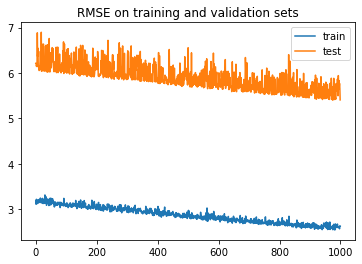

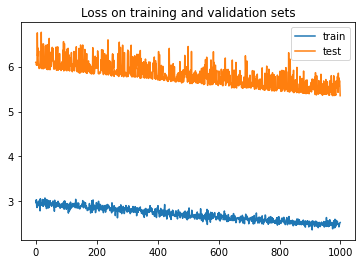

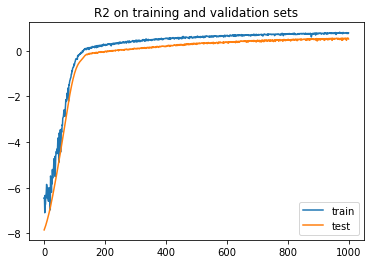

In [28]:
print("Model 3")
# Plot RMSE
plt.figure(5)
plt.plot(history_3.history['root_mean_squared_error'],label='train')
plt.plot(history_3.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
# Plot loss
plt.figure(6)
plt.plot(history_3.history['loss'],label='train')
plt.plot(history_3.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()
plt.figure()
plt.plot(history_1.history['R2'],label='train')
plt.plot(history_1.history['val_R2'],label='test')
plt.legend()
plt.title('R2 on training and validation sets')
plt.show()

### Reconsideration
At this point i realize that keras models are not working well with custom made layers such as the one RBF I made. After research and communication with a professor,
I came to an understanding that RBF layer is just a kernel that could be applied to data and the we can instantly proceed adn push that data to the output layer.
So because I have no time for debugging im using sklearn to create a custom rbf kernel from pairwise lib and I apply this to a specific number of data inputs in order to have the correct. Last but not least I want to point out that there are implementation of creating rbf Layers that work with keras and I found some but they are not quite effective thats why I made the training epochs 1000.


The two cells bellow where a try to make rbf kernel and aply it to data but I found a way to fix the rbf_layer that i create so they are not included in deliverable cause I didnt finish the Process bellow

In [17]:
from sklearn.metrics.pairwise import rbf_kernel

# apply kmeans to find initial centers
km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
centers = km.cluster_centers_
# typecast 1/2sigma to float vector in order to be applied to kernel
x_rbf_out = rbf_kernel(x_train,Y =centers, gamma = np.float32( 1/(2*sigma)) )


### Create output layer model builder function

In [18]:
def output_layer_builder():
    model_out = models.Sequential()
    # RBF layer kernel applied to data as transformation
    # Output Layer
    model_out.add(layers.Dense(128, activation='relu', input_shape=(x_rbf_out.shape[1],),
                         kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))
    
    # Make the linear tranformation layer on the output layer
    model_out.add(layers.Dense(1,activation='relu',
                  kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
    model_out.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])

Train Model 1

In [20]:

model_1 = output_layer_builder()
history_1 = model_1.fit(x_rbf_out,y_train,epochs=100,batch_size=48,validation_split=0.2,verbose=1)

# Plot RSQ
plt.figure(1)
plt.plot(history.history['RSquare'])





# Plot RMSE
plt.figure(1)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

AttributeError: ignored

# PART 2 := RBF MODEL TUNING

In this part of the task I am going to use a tuning method to find the optimal hyperparameters from the set bellow. In the RBFNet we also add a dropout Regulization Layer in the output of hidden layer 2

Hyperparameters
* number of the neurons of RBF layer n_rbf:={5%,15%,30%,50% / of Training set size}
* number of the neurons of the second hidden layer n_hidden_2:={32,64,128,257}
* dropout_rate with probability p {0.2,0.35,0.5}

The tuning method I selected is GridSearch with 5-fold Cross Validation as applied in TSK Regression project

In [21]:
from sklearn.model_selection import KFold
# 5-fold cross-val to choose the optimal hyperparameters
kfold = KFold(n_splits=5,shuffle=True)
# hp_n_rbf = number of centers Kmeans = number of neurons in RBF layer
hp_n_rbf = np.array([int(0.05*x_train.shape[0]), int(0.15*x_train.shape[0]),
                        int(0.3*x_train.shape[0]), int(0.5*x_train.shape[0])])
# 2nd hyperparameter: Number of neurons in output layer
hp_n_hidden_2 = np.array([32, 64, 128, 256])
# 3rd hyperparameter: probability of dropout in output layer
dropout_p = np.array([0.2, 0.35, 0.5])

In [22]:
# Cross Validation folds are 5 so mse_cv and rmse_cv are the temp buffers to store the metrics
mse_cv = np.zeros(5)
rmse_cv = np.zeros(5)

# Grid parameters
optimal_rmse = float('inf')
optimal_n_rbf = None
optimal_n_hidden_2 = None
optimal_droput_p = None
optimal_mse = None
optimal_rbf_out = None
otpimal_centers = None
model_index = 1;
for r in hp_n_rbf:
    n_centers = r
    km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
    centers = km.cluster_centers_
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
    
    for i in hp_n_hidden_2:
        
        for j in dropout_p:
            fold = 0
           
            for train_cv, test_cv in kfold.split(x_train,y_train):
                print('Fold #{}'.format(fold))
                model_cv = models.Sequential()
                rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

                rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
                model_cv.add(rbf_layer)

                # Output Layer
                model_cv.add(layers.Dense(i,activation='relu',input_shape=rbf_out_shape,
                                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))
                # Add Dropout Layer
                model_cv.add(layers.Dropout(j))
                # Make the linear tranformation layer on the output layer
                model_cv.add(layers.Dense(1,activation='relu',
                                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
                model_cv.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                                    loss = tf.keras.losses.MeanSquaredError(),
                                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
                #Early stopping at 20 epochs because we saw from expermiments before that it converges quite fast
                stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'root_mean_squared_error',
                                                            mode = 'min',
                                                            patience = 20,
                                                            verbose=0)
                history_3 = model_cv.fit(x_train[train_cv],y_train[train_cv],epochs=100,batch_size=32,callbacks=[stop_early],validation_split=0.2,verbose=1)
                
                # get metrics
                metrics = model_cv.evaluate(x_train[test_cv],y_train[test_cv])
                mse_cv[fold] = metrics[0]
                rmse_cv[fold] = metrics[0]
                fold+=1 
                    
            # Take the mean metrics
            mse = np.mean(mse_cv)
            rmse = np.mean(rmse_cv)
            
            print('For Model {}'.format(model_index))
            print('Number of RBF layer nodes: {}'.format(r))
            print('Number of hidden layer 2 nodes: {}'.format(i))
            print('Dropout p value = {} '.format(j))
            print('Model RMSE: {}'.format(rmse))
            print('Model MSE: {}'.format(mse))
            
            
            model_index += 1
            
            # Set best parameters
            if(rmse < optimal_rmse):
                optimal_rmse = rmse
                optimal_n_hidden_2_ = i
                optimal_droput_p = j
                optimal_n_rbf =  r
                optimal_rbf_out = rbf_out_shape
                otpimal_centers = centers
                
print('Optimal parameters for the model:')
print('Number of RBF layer nodes: {}'.format(optimal_n_rbf))
print('Neurons in output layer: {}'.format(optimal_n_hidden_2))
print('p = {}'.format(optimal_droput_p))

print('RMSE: {}'.format(optimal_rmse))
print('MSE: {}'.format(optimal_mse))


Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 8ms/step - loss: 147.8165 - root_mean_squared_error: 12.1580 - R2: -0.9728 - val_loss: 232.6836 - val_root_mean_squared_error: 15.2540 - val_R2: -0.8098
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 111.4262 - root_mean_squared_error: 10.5559 - R2: -0.4018 - val_loss: 194.0889 - val_root_mean_squared_error: 13.9316 - val_R2: -0.5079
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 97.7819 - root_mean_squared_error: 9.8885 - R2: -0.2810 - val_loss: 178.2550 - val_root_mean_squared_error: 13.3512 - val_R2: -0.3838
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 92.9708 - root_mean_squared_error: 9.6421 - R2: -0.1893 - val_loss: 170.5963 - val_root_mean_squared_error: 13.0612 - val_R2: -0.3239
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 93.6648 - root_mean_squared_error: 9.6781 - R2: -0.1786 - val_l

Basically the optimal parameters selected are (Had an issue on the last run it shows NaN due to runtime crash - I wasnt able to run this again because it takes aproximately 1 hour)

RBF neurons 56 = Kernel Centers

p = 0.35

Output Layer neurons = 256

Train the optimal model

In [11]:
optimal_model = models.Sequential()
rbf_layer = RBFLayer(units = 56,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
optimal_model.add(rbf_layer)

# Output Layer
optimal_model.add(layers.Dense(256,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))
# Dopout Layer
optimal_model.add(layers.Dropout(0.35))
# Make the linear tranformation layer on the output layer
optimal_model.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
optimal_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
optimal_model.summary()
# I train the model for more epochs 
history_opt = optimal_model.fit(x_train,y_train,epochs=1000,batch_size=32,validation_split=0.2,verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_1 (RBFLayer)      (None, 56)                784       
                                                                 
 dense_2 (Dense)             (None, 256)               14592     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15,633
Trainable params: 15,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 1s 24ms/step - loss: 477.7376 - root_mean_squared_error: 21.8572 - R2: -6.0240 - val_loss: 507.9679 - val_root_mean_squared_erro

Plot Results RMSE metric and Loss slopes for training and validation sets

Optimal Model


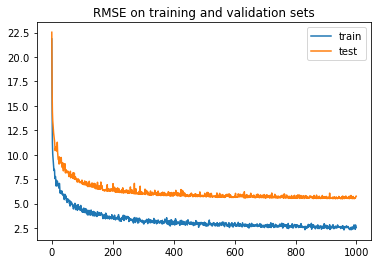

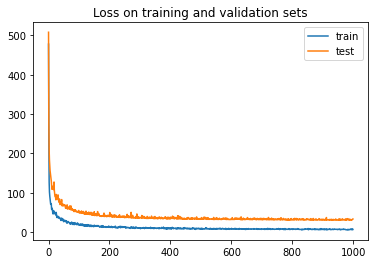

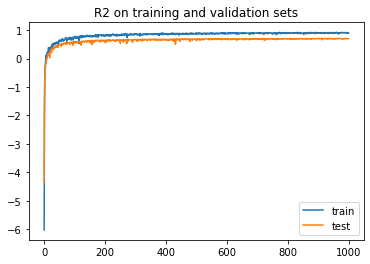

In [12]:
print("Optimal Model")
# Plot RMSE
plt.figure(7)
plt.plot(history_opt.history['root_mean_squared_error'],label='train')
plt.plot(history_opt.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
# Plot loss
plt.figure(8)
plt.plot(history_opt.history['loss'],label='train')
plt.plot(history_opt.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()
plt.figure()
plt.plot(history_opt.history['R2'],label='train')
plt.plot(history_opt.history['val_R2'],label='test')
plt.legend()
plt.title('R2 on training and validation sets')
plt.show()

In [54]:
# Evaluation Test
slice_length = 127
data_length = x_train.shape[0]
max_offset = data_length - slice_length
random_offset = tf.random.uniform((), minval=0, maxval=max_offset, dtype=tf.dtypes.int64)
slice_indices = tf.range(0, slice_length, dtype=tf.dtypes.int64)
random_slice = tf.gather(x_train, slice_indices + random_offset, axis=0)
metrics = optimal_model.evaluate(random_slice,y_test,verbose=1)

print('For the test set:')
print('MSE: {}'.format(metrics[0]))
print('RMSE: {}'.format(metrics[1]))

4/4 [==============================] - 0s 1ms/step - loss: 168.8268 - root_mean_squared_error: 12.9933 - R2: -1.2908
For the test set:
MSE: 168.8268280029297
RMSE: 12.993337631225586
